# Smooth and flux-calibrate the input spectra to match the ETC.

The goal of this notebook is to see if we can reproduce the NIRSpec/prism spectra produced by the JWST/ETC (which are in e-/s) by smoothing and "unfluxing" (i.e., applying the throughput curves) the input spectra, which are in mJy.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.table import Table

from prospect.utils.smoothing import smoothspec

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [21]:
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters', 'etc' )
pandeia_dir = os.path.join( os.getenv('IM_DATA_DIR'), 'pandeia_data-1.0' )

### Read the instrumental resolution. 

In [22]:
dispfile = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'dispersion', 'jwst_nirspec_prism_disp.fits')
print('Reading {}'.format(dispfile))
disp = Table(fitsio.read(dispfile, ext=1, upper=True))

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/dispersion/jwst_nirspec_prism_disp.fits


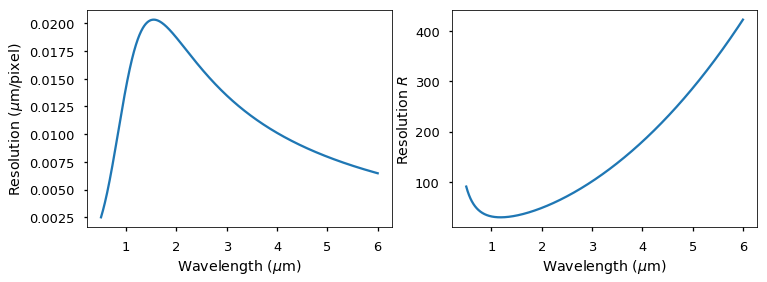

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(disp['WAVELENGTH'], disp['DLDS'])
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Resolution ($\mu$m/pixel)')

ax[1].plot(disp['WAVELENGTH'], disp['R'])
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Resolution $R$')

### Read the detector QE and throughput.

In [35]:
qefile = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'qe', 'jwst_nirspec_qe.fits')
print('Reading {}'.format(qefile))
qe = Table(fitsio.read(qefile, ext=1, upper=True))

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/qe/jwst_nirspec_qe.fits


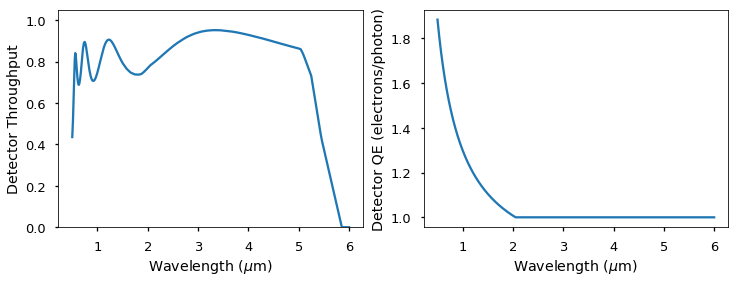

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(qe['WAVELENGTH'], qe['THROUGHPUT'])
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Detector Throughput')
ax[0].set_ylim(0, 1.05)

ax[1].plot(qe['WAVELENGTH'], qe['CONVERSION'])
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Detector QE (electrons/photon)')

### Get the total optical throughput.

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/blaze/jwst_nirspec_prism_speceff.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/filters/jwst_nirspec_clear_trans.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/optical/jwst_nirspec_mos_internaloptics_throughput.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/telescope/jwst_telescope_ote_thruput.fits


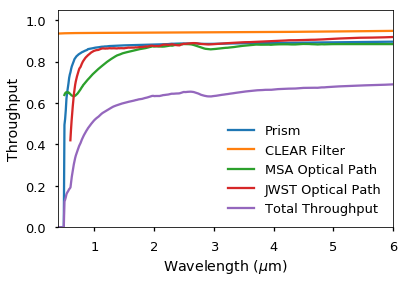

In [34]:
thru_prism = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'blaze', 
                          'jwst_nirspec_prism_speceff.fits') # prism throughput
thru_clear = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'filters', 
                          'jwst_nirspec_clear_trans.fits') # CLEAR filter throughput 
thru_optics = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'optical', 
                           'jwst_nirspec_mos_internaloptics_throughput.fits') # NIRSpec MSA optical path
thru_telescope = os.path.join(pandeia_dir, 'jwst', 'telescope', 
                              'jwst_telescope_ote_thruput.fits') # JWST optical path
labels = ['Prism', 'CLEAR Filter', 'MSA Optical Path', 'JWST Optical Path']

thru = []

for lab, thrufile in zip( labels, (thru_prism, thru_clear, thru_optics, thru_telescope) ):
    print('Reading {}'.format(thrufile))
    tt = Table(fitsio.read(thrufile, ext=1, upper=True))
    thru.append(tt)
    if 'Prism' in lab:
        throughput_wave = tt['WAVELENGTH']
    plt.plot(tt['WAVELENGTH'], tt['THROUGHPUT'], label=lab)
    
throughput = np.ones_like(throughput_wave)
for tt in thru:
    throughput *= np.interp(throughput_wave, tt['WAVELENGTH'], tt['THROUGHPUT'])
plt.plot(throughput_wave, throughput, label='Total Throughput')

plt.xlim(throughput_wave.min(), throughput_wave.max())
plt.ylim(0, 1.05)
plt.ylabel('Throughput')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend(loc='lower right', frameon=False)   

### Read the input model spectra and compare to the ETC spectra.

The goal here is to try to use all the detector components to try to "flux-calibrate" the input spectra (after smoothing by the wavelength-dependent line-spread function).  We convert from F_nu to F_lambda, multiply by the total (optical) throughput, the detector throughput, and the detector QE.  

Unfortunately, I'm missing a couple more fluxing factors that I'm having trouble tracking down, so we just derive them empirically, averaged over all the input spectra.

Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_00.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_01.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_02.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_03.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_04.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_05.txt


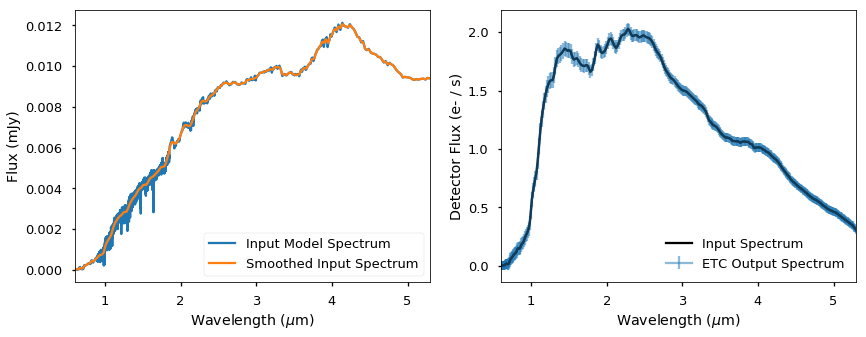

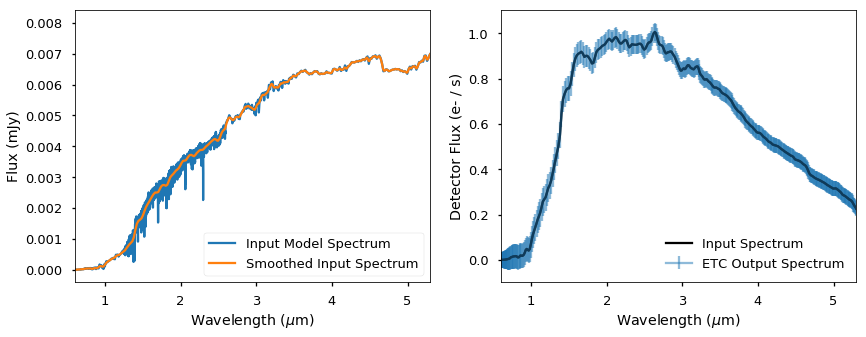

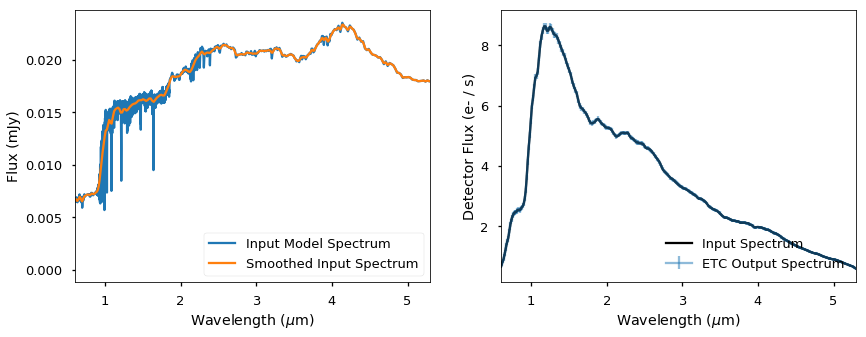

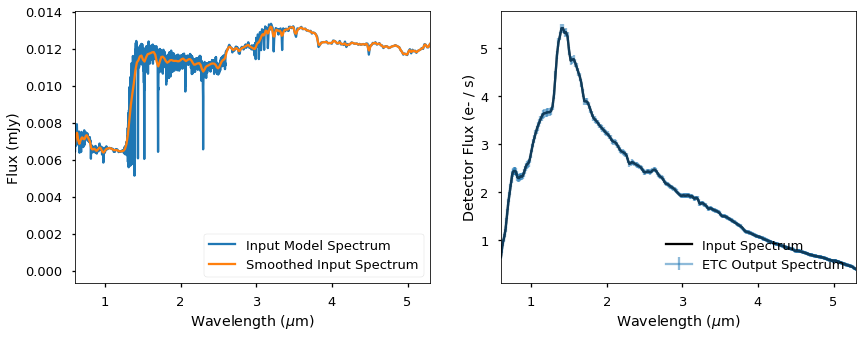

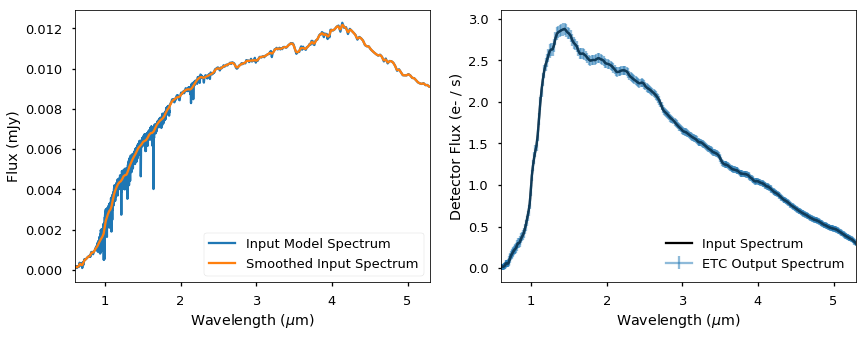

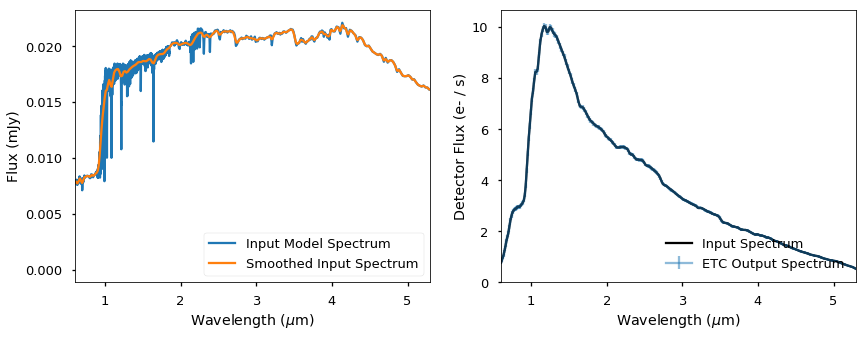

In [67]:
allfluxvector = []

for suffix in ('00', '01', '02', '03', '04', '05'):
    infile = os.path.join(jwstdir, 'input', 'modelspec_{}.txt'.format(suffix))
    print('Reading {}'.format(infile))
    inwave, influx = np.loadtxt(infile, unpack=True) # [micron, mJy]
    
    outfile = os.path.join(jwstdir, 'output', suffix, 'lineplot', 'lineplot_extracted_flux.fits')
    snrfile = os.path.join(jwstdir, 'output', suffix, 'lineplot', 'lineplot_sn.fits')
    simspec = Table(fitsio.read(outfile, ext=1, upper=True))
    snrspec = Table(fitsio.read(snrfile, ext=1, upper=True))

    outwave = simspec['WAVELENGTH']
    detector_throughput = np.interp(outwave, qe['WAVELENGTH'], qe['THROUGHPUT'])
    detector_qe = np.interp(outwave, qe['WAVELENGTH'], qe['CONVERSION']) # electrons / photon
    
    total_throughput = np.interp(outwave, throughput_wave, throughput)
    
    resolution = np.interp(inwave, disp['WAVELENGTH'], disp['DLDS'])    
    smoothflux = smoothspec(inwave, influx, resolution=resolution, smoothtype='lsf', 
                            outwave=outwave, fftsmooth=True)

    prismflux = (detector_qe * detector_throughput * total_throughput *
                smoothflux * 2.998e14 / outwave**2)
    
    #dw = np.gradient(outwave)
    #prismflux = (detector_throughput * total_throughput * 1e-26 * # erg/s/cm2/A
    #             smoothflux * 2.998e14 / outwave**2)
    #prismflux *= (dw * 1e-4) * (1e-4 * outwave) / (6.626e-27 * 2.998e10) # photon/s/cm2
    #prismflux *= detector_qe # electron/s/cm2

    fluxratio = simspec['EXTRACTED_FLUX'] / prismflux
    fluxvector = (fluxratio * detector_qe * detector_throughput * 
                  total_throughput * 2.998e14 / outwave**2)
    allfluxvector.append(fluxvector)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    #fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex=True)
    ax[0].plot(inwave, influx, label='Input Model Spectrum')
    ax[0].plot(outwave, smoothflux, label='Smoothed Input Spectrum')
    ax[0].set_ylabel('Flux (mJy)')
    ax[0].set_xlabel('Wavelength ($\mu$m)')
    ax[0].legend(loc='lower right')

    ax[1].errorbar(simspec['WAVELENGTH'], simspec['EXTRACTED_FLUX'], 
                   simspec['EXTRACTED_FLUX'] / snrspec['SN'], 
                   label='ETC Output Spectrum', alpha=0.5)
    ax[1].plot(outwave, smoothflux * fluxvector, color='k', label='Input Spectrum')

    ax[1].set_ylabel('Detector Flux (e- / s)')
    ax[1].set_xlabel('Wavelength ($\mu$m)')
    ax[1].legend(loc='lower right', frameon=False)
        
    #ax[2].plot(outwave, fluxratio)
    #ax[2].set_ylim(0, 9e-12)

    [xx.set_xlim(outwave.min(), outwave.max()) for xx in ax]